In [6]:
# For streaming
import sys
version = sys.version_info
if version.major < 3 or (version.major == 3 and version.minor < 10):
    raise RuntimeError("This script requires Python 3.10 or higher")
import os
from typing import Iterable

from fileStreams import getFileJsonStream
from utils import FileProgressLog

# For processing
import gensim
from gensim.models import Word2Vec
import re
import logging
from tqdm import tqdm
import json
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models.phrases import Phrases, Phraser
    
import datetime
import random
import numpy as np


filePathforDemocrats = r"datasets/democrats_comments.zst"
filePathforRepublican = r"datasets/Republican_comments.zst"
filePathforBackpacking = r"datasets/backpacking_comments.zst"
filePathforvagabond = r"datasets/vagabond_comments.zst"
recursive = False


def processFile(path, party, without_stopwords=True):
    # Set seeds for reproducibility
    random.seed(23)
    np.random.seed(23)
    
    print(f"Processing file {path}")
    
    # # Download necessary NLTK resources
    # nltk.download('stopwords', quiet=True)
    # nltk.download('wordnet', quiet=True)
    # nltk.download('punkt', quiet=True)
    # nltk.download('averaged_perceptron_tagger', quiet=True)  # For POS tagging
    
    # Initialize lemmatizer and stop words
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    # Add lemma cache
    lemma_cache = {}

    # Create empty lists for each time period
    chunks = {
        "before_2016": [],
        "2017_2020": [],
        "2021_2024": [],
    }
    
    # Track counts
    counts = {period: 0 for period in chunks.keys()}
    
    POS_CACHE = {}
    LEMMA_CACHE = {}
    
    with open(path, "rb") as f:
        jsonStream = getFileJsonStream(path, f)
        if jsonStream is None:
            print(f"Skipping unknown file {path}")
            return
        for row in tqdm(jsonStream, desc="Processing comments"):
            if "body" not in row or "created_utc" not in row:
                continue
            
            # Get the comment text and timestamp
            text = row["body"]
            created_timestamp = row["created_utc"]
            
            # Convert timestamp to year
            year = datetime.datetime.fromtimestamp(int(created_timestamp)).year
            
            # Determine which chunk this comment belongs to
            chunk_key = None
            if year <= 2016:
                chunk_key = "before_2016"
            elif 2017 <= year <= 2020:
                chunk_key = "2017_2020"
            elif 2021 <= year <= 2024:
                chunk_key = "2021_2024"
            
            # Process text
            # Remove URLs
            txt = re.sub(r'http\S+', '', text)  # Remove URLs
            
            # Remove non-alphanumeric characters and convert to lowercase
            txt = re.sub("[^A-Za-z0-9']+", ' ', txt).lower()
            
            # Replace special characters with spaces
            txt = re.sub(r"['\-_]", ' ', txt)
            
            # Tokenize
            words = txt.split()
            
            # Skip empty comments
            if not words:
                continue
            
            # Filter stop words
            if without_stopwords:
                words_to_tag = []
                for word in words:
                    if word not in stop_words:
                        words_to_tag.append(word)
            else:
                words_to_tag = words[:]
                
            if not words_to_tag:
                continue
            
            # POS Cache
            uncached_words = []
            for word in words_to_tag:
                if word not in POS_CACHE:
                    uncached_words.append(word)

            if uncached_words:
                tagged_uncached = nltk.pos_tag(uncached_words)
                for word, tag in tagged_uncached:
                    POS_CACHE[word] = tag

            processed_words = []
            for word in words_to_tag:
                tag = POS_CACHE[word]
                # Convert to wordnet_pos
                if tag.startswith('J'):
                    wordnet_pos = 'a'
                elif tag.startswith('V'):
                    wordnet_pos = 'v'
                elif tag.startswith('N'):
                    wordnet_pos = 'n'
                elif tag.startswith('R'):
                    wordnet_pos = 'r'
                else:
                    wordnet_pos = 'n'

                lemma_key = (word, wordnet_pos)
                if lemma_key in LEMMA_CACHE:
                    lemma = LEMMA_CACHE[lemma_key]
                else:
                    lemma = lemmatizer.lemmatize(word, pos=wordnet_pos)
                    LEMMA_CACHE[lemma_key] = lemma

                processed_words.append(lemma)

            if processed_words:
                chunks[chunk_key].append(processed_words)
                counts[chunk_key] += 1
                
    # Print statistics
    print("\n=== Comment Counts by Period ===")
    for period, count in counts.items():
        print(f"{period}: {count} comments")
        
    # Extract bigrams from each time period
    for period, comments in chunks.items():
        if len(comments) > 0:
            print(f"\nExtracting bigrams for {period}...")
            # Build bigram model
            phrases = Phrases(comments, min_count=5, threshold=10)
            bigram_model = Phraser(phrases)
            
            # Apply bigram model to create comments with bigrams
            bigrammed_comments = [bigram_model[comment] for comment in comments]
            chunks[period] = bigrammed_comments
        
    # Train a Word2Vec model for each time period
    for period, comments in chunks.items():
        if len(comments) > 0:
            print(f"\n=== Training Word2Vec for {period} ({len(comments)} comments) ===")
            
            # Initialize and train model
            model = Word2Vec(
                vector_size=300,
                window=5,
                min_count=5,
                workers=16,
                seed=23
            )
            
            # Build vocabulary
            model.build_vocab(comments)
            print(f"Vocabulary size: {len(model.wv.index_to_key)}")
            
            # Train the model
            model.train(
                comments, 
                total_examples=len(comments), 
                epochs=5
            )
            
            # Save the model
            model_path = f"models/model_d2/{party}_{period}.model"
            model.save(model_path)
            print(f"Model saved to {model_path}")
            
            
def main():
    output_dir = "models/model_d2"
    os.makedirs(output_dir, exist_ok=True)
    processFile(filePathforDemocrats, "democrats")
    processFile(filePathforRepublican, "republican")
    processFile(filePathforBackpacking, "backpacking")
    processFile(filePathforvagabond, "vagabond")    
    print("Done :>")

if __name__ == "__main__":
    main()


Processing file datasets/democrats_comments.zst


Processing comments: 2011525it [00:40, 49870.16it/s]



=== Comment Counts by Period ===
before_2016: 128998 comments
2017_2020: 489599 comments
2021_2024: 1373916 comments

Extracting bigrams for before_2016...

Extracting bigrams for 2017_2020...

Extracting bigrams for 2021_2024...

=== Training Word2Vec for before_2016 (128998 comments) ===
Vocabulary size: 23641
Model saved to models/model_d2/democrats_before_2016.model

=== Training Word2Vec for 2017_2020 (489599 comments) ===
Vocabulary size: 38182
Model saved to models/model_d2/democrats_2017_2020.model

=== Training Word2Vec for 2021_2024 (1373916 comments) ===
Vocabulary size: 60774
Model saved to models/model_d2/democrats_2021_2024.model
Processing file datasets/Republican_comments.zst


Processing comments: 1405486it [00:31, 44350.54it/s]



=== Comment Counts by Period ===
before_2016: 264379 comments
2017_2020: 450246 comments
2021_2024: 677821 comments

Extracting bigrams for before_2016...

Extracting bigrams for 2017_2020...

Extracting bigrams for 2021_2024...

=== Training Word2Vec for before_2016 (264379 comments) ===
Vocabulary size: 34922
Model saved to models/model_d2/republican_before_2016.model

=== Training Word2Vec for 2017_2020 (450246 comments) ===
Vocabulary size: 37105
Model saved to models/model_d2/republican_2017_2020.model

=== Training Word2Vec for 2021_2024 (677821 comments) ===
Vocabulary size: 42512
Model saved to models/model_d2/republican_2021_2024.model
Processing file datasets/backpacking_comments.zst


Processing comments: 866545it [00:24, 35731.70it/s]



=== Comment Counts by Period ===
before_2016: 160658 comments
2017_2020: 240274 comments
2021_2024: 459313 comments

Extracting bigrams for before_2016...

Extracting bigrams for 2017_2020...

Extracting bigrams for 2021_2024...

=== Training Word2Vec for before_2016 (160658 comments) ===
Vocabulary size: 28088
Model saved to models/model_d2/backpacking_before_2016.model

=== Training Word2Vec for 2017_2020 (240274 comments) ===
Vocabulary size: 27875
Model saved to models/model_d2/backpacking_2017_2020.model

=== Training Word2Vec for 2021_2024 (459313 comments) ===
Vocabulary size: 43517
Model saved to models/model_d2/backpacking_2021_2024.model
Processing file datasets/vagabond_comments.zst


Processing comments: 513168it [00:12, 39500.50it/s]



=== Comment Counts by Period ===
before_2016: 39395 comments
2017_2020: 157770 comments
2021_2024: 309467 comments

Extracting bigrams for before_2016...

Extracting bigrams for 2017_2020...

Extracting bigrams for 2021_2024...

=== Training Word2Vec for before_2016 (39395 comments) ===
Vocabulary size: 12670
Model saved to models/model_d2/vagabond_before_2016.model

=== Training Word2Vec for 2017_2020 (157770 comments) ===
Vocabulary size: 26151
Model saved to models/model_d2/vagabond_2017_2020.model

=== Training Word2Vec for 2021_2024 (309467 comments) ===
Vocabulary size: 31955
Model saved to models/model_d2/vagabond_2021_2024.model
Done :>


In [1]:
# For streaming
import sys
version = sys.version_info
if version.major < 3 or (version.major == 3 and version.minor < 10):
    raise RuntimeError("This script requires Python 3.10 or higher")
import os
from typing import Iterable

from fileStreams import getFileJsonStream
from utils import FileProgressLog

# For processing
import gensim
from gensim.models import Word2Vec
import re
import logging
from tqdm import tqdm
import json
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from gensim.models.phrases import Phrases, Phraser
    
import datetime
import random
import numpy as np
import html
import unicodedata



filePathforDemocrats = r"datasets/democrats_comments.zst"
filePathforRepublican = r"datasets/Republican_comments.zst"
recursive = False


def processFile(path, party, without_stopwords=True):
    # Set seeds for reproducibility
    random.seed(23)
    np.random.seed(23)
    
    print(f"Processing file {path}")
    
    # # Download necessary NLTK resources
    # nltk.download('stopwords', quiet=True)
    # nltk.download('wordnet', quiet=True)
    # nltk.download('punkt', quiet=True)
    # nltk.download('averaged_perceptron_tagger', quiet=True)  # For POS tagging
    
    # Initialize lemmatizer and stop words
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))

    # Create empty lists for each time period
    chunks = {
        "before_2016": [],
        "2017_2020": [],
        "2021_2024": [],
    }
    
    # Track counts
    counts = {period: 0 for period in chunks.keys()}
    
    POS_CACHE = {}
    LEMMA_CACHE = {}
    
    with open(path, "rb") as f:
        jsonStream = getFileJsonStream(path, f)
        if jsonStream is None:
            print(f"Skipping unknown file {path}")
            return
        for row in tqdm(jsonStream, desc="Processing comments"):
            if "body" not in row or "created_utc" not in row:
                continue
            
            # Get the comment text and timestamp
            text = row["body"]
            created_timestamp = row["created_utc"]
            author = row["author"]
            if author in {"AutoModerator", "election_info_bot"}:
                continue
            
            # Convert timestamp to year
            year = datetime.datetime.fromtimestamp(int(created_timestamp)).year
            
            # Determine which chunk this comment belongs to
            chunk_key = None
            if year <= 2016:
                chunk_key = "before_2016"
            elif 2017 <= year <= 2020:
                chunk_key = "2017_2020"
            elif 2021 <= year <= 2024:
                chunk_key = "2021_2024"
            
            # Process text
            # Handle HTML entities
            text = html.unescape(text)
            
            # Unicode normalization
            text = unicodedata.normalize('NFKD', text)
            
            # Remove URLs and Markdown formatting
            text = re.sub(r'http\S+', '', text)
            text = re.sub(r'!\[.*?\]\(.*?\)', '', text)
            text = re.sub(r'\[(.*?)\]\(.*?\)', r'\1', text)
            text = re.sub(r'\*\*(.*?)\*\*', r'\1', text)
            text = re.sub(r'\*(.*?)\*', r'\1', text)
            
            # Remove subreddit and user references
            text = re.sub(r'/r/\w+', '', text)
            text = re.sub(r'r/\w+', '', text)
            text = re.sub(r'/u/\w+', '', text)
            text = re.sub(r'u/\w+', '', text)
            
            # Basic text cleaning
            text = re.sub("[^A-Za-z]+", ' ', text).lower()
            
            # Remove single letters (except 'i')
            text = re.sub(r'\b([a-hj-z])\b', '', text)
            
            # Tokenize
            words = text.split()
            
            # Skip empty comments
            if not words:
                continue
            
            # Filter stop words
            if without_stopwords:
                words_to_tag = []
                for word in words:
                    if word not in stop_words:
                        words_to_tag.append(word)
            else:
                words_to_tag = words[:]
                
            if not words_to_tag:
                continue
            
            # POS Cache
            uncached_words = []
            for word in words_to_tag:
                if word not in POS_CACHE:
                    uncached_words.append(word)

            if uncached_words:
                tagged_uncached = nltk.pos_tag(uncached_words)
                for word, tag in tagged_uncached:
                    POS_CACHE[word] = tag

            processed_words = []
            for word in words_to_tag:
                tag = POS_CACHE[word]
                # Convert to wordnet_pos
                if tag.startswith('J'):
                    wordnet_pos = 'a'
                elif tag.startswith('V'):
                    wordnet_pos = 'v'
                elif tag.startswith('N'):
                    wordnet_pos = 'n'
                elif tag.startswith('R'):
                    wordnet_pos = 'r'
                else:
                    wordnet_pos = 'n'

                lemma_key = (word, wordnet_pos)
                if lemma_key in LEMMA_CACHE:
                    lemma = LEMMA_CACHE[lemma_key]
                else:
                    lemma = lemmatizer.lemmatize(word, pos=wordnet_pos)
                    LEMMA_CACHE[lemma_key] = lemma

                processed_words.append(lemma)

            if processed_words:
                chunks[chunk_key].append(processed_words)
                counts[chunk_key] += 1
                
    # Print statistics
    print("\n=== Comment Counts by Period ===")
    for period, count in counts.items():
        print(f"{period}: {count} comments")
        
    # Extract bigrams from each time period
    for period, comments in chunks.items():
        if len(comments) > 0:
            print(f"\nExtracting bigrams for {period}...")
            # Build bigram model
            phrases = Phrases(comments, min_count=5, threshold=10)
            bigram_model = Phraser(phrases)
            
            # Apply bigram model to create comments with bigrams
            bigrammed_comments = [bigram_model[comment] for comment in comments]
            chunks[period] = bigrammed_comments
        
    # Train a Word2Vec model for each time period
    for period, comments in chunks.items():
        if len(comments) > 0:
            print(f"\n=== Training Word2Vec for {period} ({len(comments)} comments) ===")
            
            # Initialize and train model
            model = Word2Vec(
                vector_size=300,
                window=5,
                min_count=5,
                workers=16,
                seed=23
            )
            
            # Build vocabulary
            model.build_vocab(comments)
            print(f"Vocabulary size: {len(model.wv.index_to_key)}")
            
            # Train the model
            model.train(
                comments, 
                total_examples=len(comments), 
                epochs=5
            )
            
            # Save the model
            model_path = f"models/model_d3/{party}_{period}.model"
            model.save(model_path)
            print(f"Model saved to {model_path}")
            
            
def main():
    output_dir = "models/model_d3"
    os.makedirs(output_dir, exist_ok=True)
    processFile(filePathforDemocrats, "democrats")
    processFile(filePathforRepublican, "republican")
    # processFile(filePathforBackpacking, "backpacking")
    # processFile(filePathforvagabond, "vagabond")    
    print("Done :>")

if __name__ == "__main__":
    main()


Processing file datasets/democrats_comments.zst


Processing comments: 2011525it [00:49, 40648.62it/s]



=== Comment Counts by Period ===
before_2016: 127372 comments
2017_2020: 473415 comments
2021_2024: 1334650 comments

Extracting bigrams for before_2016...

Extracting bigrams for 2017_2020...

Extracting bigrams for 2021_2024...

=== Training Word2Vec for before_2016 (127372 comments) ===
Vocabulary size: 22382
Model saved to models/model_d3/democrats_before_2016.model

=== Training Word2Vec for 2017_2020 (473415 comments) ===
Vocabulary size: 36387
Model saved to models/model_d3/democrats_2017_2020.model

=== Training Word2Vec for 2021_2024 (1334650 comments) ===
Vocabulary size: 57501
Model saved to models/model_d3/democrats_2021_2024.model
Processing file datasets/Republican_comments.zst


Processing comments: 1405486it [00:37, 37735.42it/s]



=== Comment Counts by Period ===
before_2016: 263823 comments
2017_2020: 415293 comments
2021_2024: 613344 comments

Extracting bigrams for before_2016...

Extracting bigrams for 2017_2020...

Extracting bigrams for 2021_2024...

=== Training Word2Vec for before_2016 (263823 comments) ===
Vocabulary size: 33050
Model saved to models/model_d3/republican_before_2016.model

=== Training Word2Vec for 2017_2020 (415293 comments) ===
Vocabulary size: 35476
Model saved to models/model_d3/republican_2017_2020.model

=== Training Word2Vec for 2021_2024 (613344 comments) ===
Vocabulary size: 40697
Model saved to models/model_d3/republican_2021_2024.model
Done :>


In [2]:
import numpy as np
import pandas as pd
import gensim
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity
import os

def compare_subreddit_embeddings_by_period(model1, model2, subreddit1_name, subreddit2_name, time_period, output_file=None):
    """Compare two word2vec models by aligning their vector spaces and measuring word similarities"""
    # Find common vocabulary
    vocab1 = set(model1.wv.index_to_key)
    vocab2 = set(model2.wv.index_to_key)
    common_vocab = list(vocab1.intersection(vocab2))

    print(f"{time_period}: Common vocabulary between {subreddit1_name} and {subreddit2_name}: {len(common_vocab)} words")
    
    # Extract embeddings for common words
    vectors1 = np.array([model1.wv[word] for word in common_vocab])
    vectors2 = np.array([model2.wv[word] for word in common_vocab])
    
    # Compute the best rotational alignment (orthogonal Procrustes)
    m = vectors1.T @ vectors2
    u, _, vt = np.linalg.svd(m)
    rotation = u @ vt
    
    # Apply rotation to align model2's space with model1's space
    vectors2_aligned = vectors2 @ rotation
    
    # Calculate word by word similarities
    similarities = []
    for i, word in enumerate(common_vocab):
        sim = cosine_similarity(vectors1[i].reshape(1, -1), 
                                vectors2_aligned[i].reshape(1, -1))[0][0]
        similarities.append((word, sim))
    
    # Create DataFrame
    df = pd.DataFrame(similarities, columns=['word', 'similarity'])
    
    # Sort by similarity (most different words first)
    df = df.sort_values('similarity')
    
    # Save to file if requested
    if output_file:
        # Create directory if it doesn't exist
        os.makedirs(os.path.dirname(output_file), exist_ok=True)
        df.to_csv(output_file, index=False)
        print(f"Results saved to {output_file}")
    
    return df

# Democrats vs Republicans
democrats_before_2016 = gensim.models.Word2Vec.load("models/model_d3/democrats_before_2016.model")
democrats_2017_2020 = gensim.models.Word2Vec.load("models/model_d3/democrats_2017_2020.model")
democrats_2021_2024 = gensim.models.Word2Vec.load("models/model_d3/democrats_2021_2024.model")
republican_before_2016 = gensim.models.Word2Vec.load("models/model_d3/republican_before_2016.model")
republican_2017_2020 = gensim.models.Word2Vec.load("models/model_d3/republican_2017_2020.model")
republican_2021_2024 = gensim.models.Word2Vec.load("models/model_d3/republican_2021_2024.model")
# backpacking_before_2016 = gensim.models.Word2Vec.load("models/model_d2/backpacking_before_2016.model")
# backpacking_2017_2020 = gensim.models.Word2Vec.load("models/model_d2/backpacking_2017_2020.model")
# backpacking_2021_2024 = gensim.models.Word2Vec.load("models/model_d2/backpacking_2021_2024.model")
# vagabond_before_2016 = gensim.models.Word2Vec.load("models/model_d2/vagabond_before_2016.model")
# vagabond_2017_2020 = gensim.models.Word2Vec.load("models/model_d2/vagabond_2017_2020.model")
# vagabond_2021_2024 = gensim.models.Word2Vec.load("models/model_d2/vagabond_2021_2024.model")


# Define output directory
output_dir = "output/d3"
os.makedirs(output_dir, exist_ok=True)

print("\nComparing models:")
# Before 2016

compare_subreddit_embeddings_by_period(
    republican_before_2016, 
    democrats_before_2016,
    "republican", 
    "democrats",
    "before_2016",
    output_file=f"{output_dir}/republican_democrats_before_2016.csv"
)

# compare_subreddit_embeddings_by_period(
#     backpacking_before_2016, 
#     vagabond_before_2016,
#     "backpacking", 
#     "vagabond",
#     "before_2016",
#     output_file=f"{output_dir}/backpacking_vagabond_before_2016.csv"
# )

# 2017-2020

compare_subreddit_embeddings_by_period(
    republican_2017_2020, 
    democrats_2017_2020,
    "republican", 
    "democrats",
    "2017_2020",
    output_file=f"{output_dir}/republican_democrats_2017_2020.csv"
)


# compare_subreddit_embeddings_by_period(
#     backpacking_2017_2020, 
#     vagabond_2017_2020,
#     "backpacking", 
#     "vagabond",
#     "2017_2020",
#     output_file=f"{output_dir}/backpacking_vagabond_2017_2020.csv"
# )

# 2021-2024

compare_subreddit_embeddings_by_period(
    republican_2021_2024, 
    democrats_2021_2024,
    "republican", 
    "democrats",
    "2021_2024",
    output_file=f"{output_dir}/republican_democrats_2021_2024.csv"
)


# compare_subreddit_embeddings_by_period(
#     backpacking_2021_2024, 
#     vagabond_2021_2024,
#     "backpacking", 
#     "vagabond",
#     "2021_2024",
#     output_file=f"{output_dir}/backpacking_vagabond_2021_2024.csv"
# )


print("\nAnalysis complete. Generated 6 comparison files.")


Comparing models:
before_2016: Common vocabulary between republican and democrats: 17583 words
Results saved to output/d3/republican_democrats_before_2016.csv
2017_2020: Common vocabulary between republican and democrats: 24319 words
Results saved to output/d3/republican_democrats_2017_2020.csv
2021_2024: Common vocabulary between republican and democrats: 30301 words
Results saved to output/d3/republican_democrats_2021_2024.csv

Analysis complete. Generated 6 comparison files.


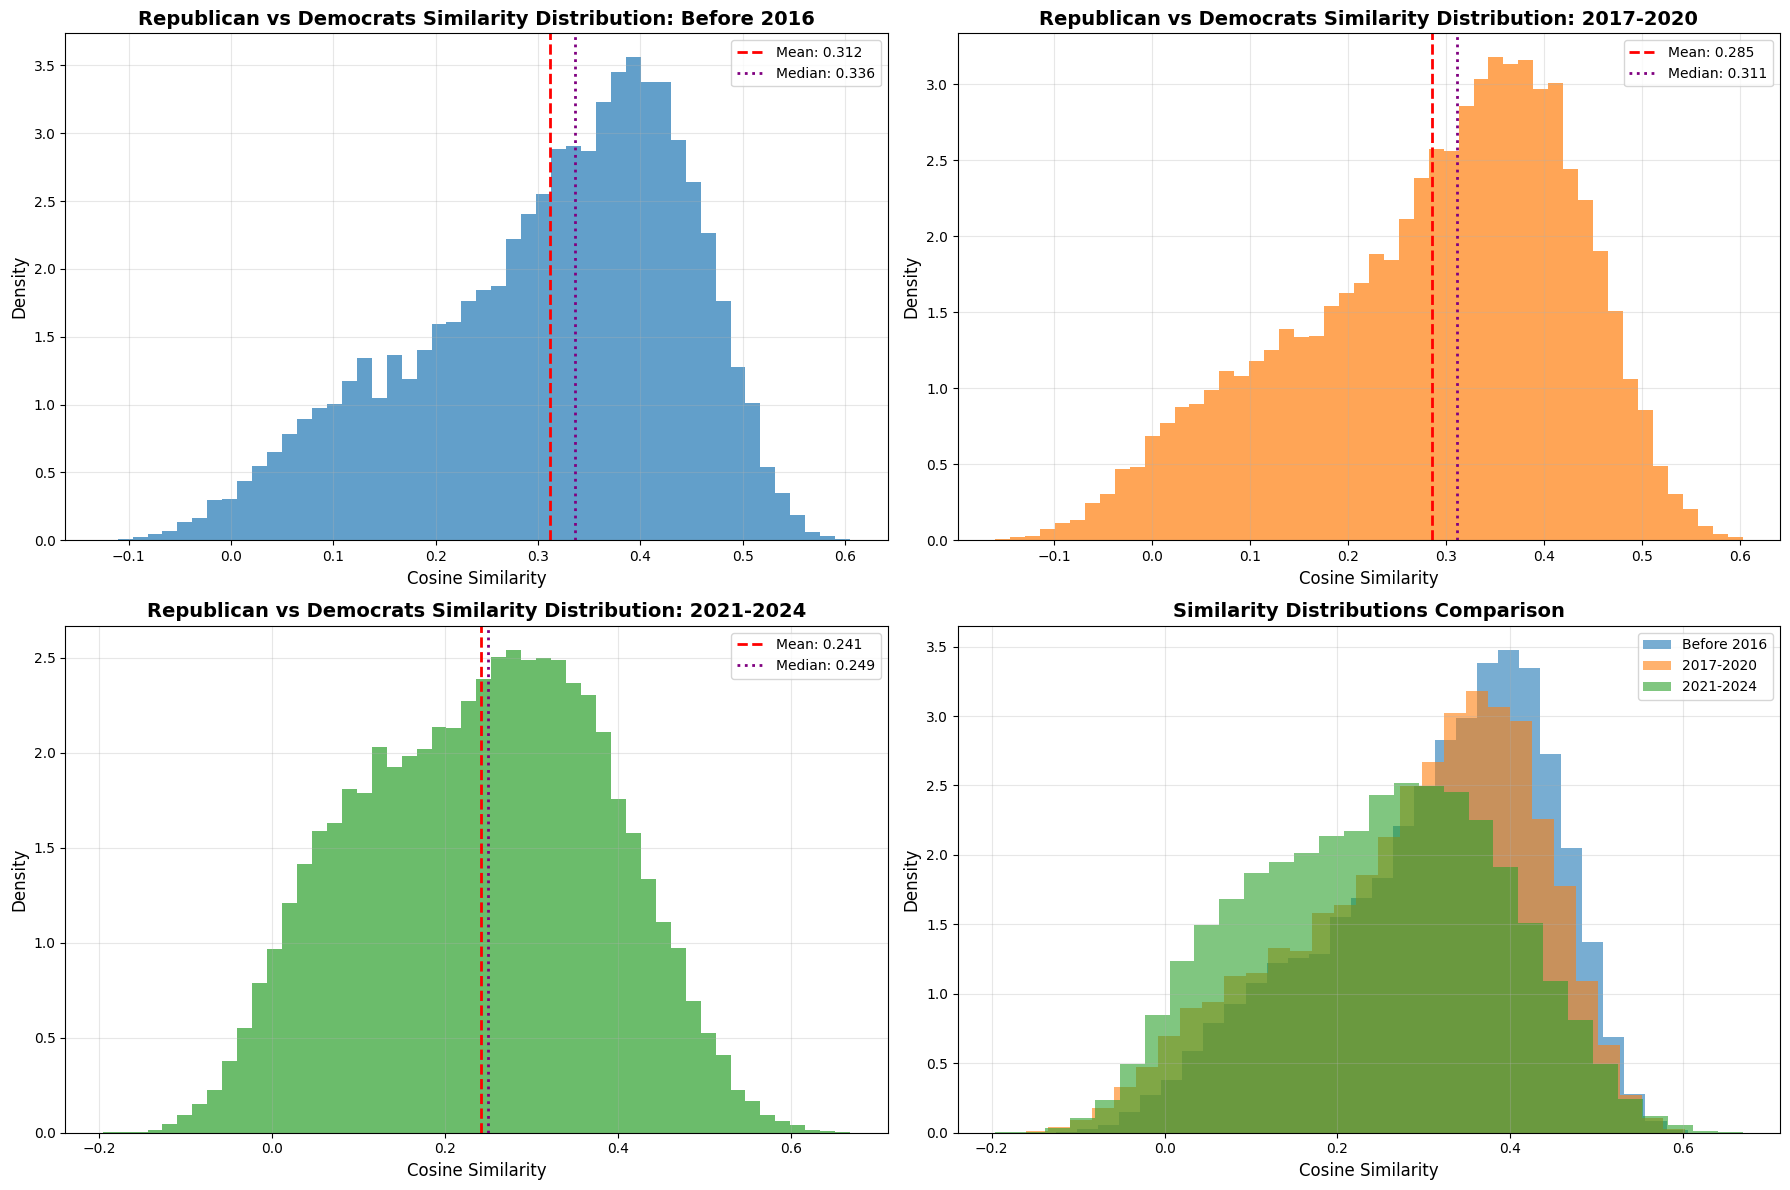

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

def analyze_similarity_distributions(df_before_2016, df_2017_2020, df_2021_2024, subreddit1, subreddit2):
    """Analyze how cosine similarity distributions change over time"""
    
    # Prepare data
    dataframes = [df_before_2016, df_2017_2020, df_2021_2024]
    period_names = ['Before 2016', '2017-2020', '2021-2024']
    
    # Create the plot
    plt.figure(figsize=(18, 12))
    
    # Main distribution plots
    for i, (df, period) in enumerate(zip(dataframes, period_names)):
        plt.subplot(2, 2, i+1)
        
        # Create histogram
        plt.hist(df['similarity'], bins=50, alpha=0.7, density=True, 
                color=['#1f77b4', '#ff7f0e', '#2ca02c'][i])
        
        # Add statistics
        mean_sim = df['similarity'].mean()
        std_sim = df['similarity'].std()
        median_sim = df['similarity'].median()
        
        plt.axvline(mean_sim, color='red', linestyle='--', linewidth=2,
                   label=f'Mean: {mean_sim:.3f}')
        plt.axvline(median_sim, color='purple', linestyle=':', linewidth=2,
                   label=f'Median: {median_sim:.3f}')

        plt.title(f'{subreddit1} vs {subreddit2} Similarity Distribution: {period}', fontsize=14, fontweight='bold')
        plt.xlabel('Cosine Similarity', fontsize=12)
        plt.ylabel('Density', fontsize=12)
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    # Combined comparison plot
    plt.subplot(2, 2, 4)
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    for i, (df, period, color) in enumerate(zip(dataframes, period_names, colors)):
        plt.hist(df['similarity'], bins=30, alpha=0.6, density=True, 
                label=period, color=color)
    
    plt.title('Similarity Distributions Comparison', fontsize=14, fontweight='bold')
    plt.xlabel('Cosine Similarity', fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f"output/d3/{subreddit1}_{subreddit2}_similarity_distributions.png")
    plt.show()



# Run the analysis
# Read the CSV files
republican_democrats_before_2016 = pd.read_csv("output/d3/republican_democrats_before_2016.csv")
republican_democrats_2017_2020 = pd.read_csv("output/d3/republican_democrats_2017_2020.csv")
republican_democrats_2021_2024 = pd.read_csv("output/d3/republican_democrats_2021_2024.csv")
# backpacking_vagabond_before_2016 = pd.read_csv("output/d3/backpacking_vagabond_before_2016.csv")
# backpacking_vagabond_2017_2020 = pd.read_csv("output/d3/backpacking_vagabond_2017_2020.csv")
# backpacking_vagabond_2021_2024 = pd.read_csv("output/d3/backpacking_vagabond_2021_2024.csv")


analyze_similarity_distributions(
    republican_democrats_before_2016, 
    republican_democrats_2017_2020, 
    republican_democrats_2021_2024, 
    "Republican", 
    "Democrats"
    )

# analyze_similarity_distributions(
#     backpacking_vagabond_before_2016, 
#     backpacking_vagabond_2017_2020, 
#     backpacking_vagabond_2021_2024, 
#     "Backpacking", 
#     "Vagabond"
#     )
